In [1]:
%matplotlib inline
from keras.models import model_from_json
import categories
import configs.test_config as config
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
models_arch = []
rng = len(os.listdir(config.agent_path))
accs = []
for i in range(1, rng):
    with open(config.agent_path + '/Model_v{}/arch.json'.format(i), 'r') as f:
        models_arch.append(model_from_json(f.read()))
    file = open(config.agent_path + "/Model_v{}/info.txt".format(i))
    for line in file:
        if "Accuracy" in line:
            acc = line.split(":")[-1]
            accs.append((acc, "Model {}".format(i)))
sorted(accs)

[(' 0.9660483024151207', 'Model 1'), (' 0.968498424921246', 'Model 2')]

In [3]:
dct = {}
for i in range(1, rng):
    with open(config.agent_path + '/Model_v{0}/arch.json'.format(i), 'r') as f:
            dct["model{}".format(i)] = model_from_json(f.read())
    dct["model{}".format(i)].load_weights(config.agent_path + '/Model_v{0}/model.hdf5'.format(i))

In [4]:
import operator

def ensemble(results, threshold="max", select="all"):
    dct = {}
    index = 1
    for result in results:
        if select == "all":
            result = results[result][0]
            for i, conf in enumerate(result):
                if i not in dct:
                    dct[i] = conf
                else:
                    dct[i] += conf
        else:
            if index in select:
                result = results[result][0]
                for i, conf in enumerate(result):
                    if i not in dct:
                        dct[i] = conf
                    else:
                        dct[i] += conf
        index += 1
    for key in dct:
        dct[key] = dct[key] / len(results)
    if threshold == "max":
        cls = max(dct.items(), key=operator.itemgetter(1))
    else:
        if abs(dct[0] - dct[1]) < threshold:
            cls = [0]
        else:
            cls = max(dct.items(), key=operator.itemgetter(1))
    return cls

In [5]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.util import img_as_ubyte
from skimage import morphology, img_as_bool
import os


def skeletonize(img):
    image = img_as_bool(img)
    out = morphology.medial_axis(image)
    return img_as_ubyte(out)

Test_image/Crop_hand/num\0.jpg
Predict: negative 
True: number


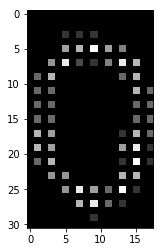

Test_image/Crop_hand/num\1.jpg
Predict: number 
True: number


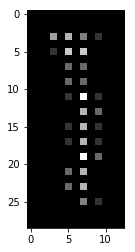

Test_image/Crop_hand/num\2.jpg
Predict: number 
True: number


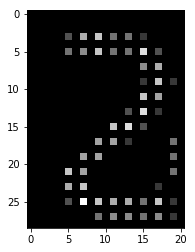

Test_image/Crop_hand/num\3.jpg
Predict: number 
True: number


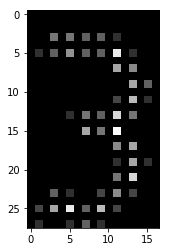

Test_image/Crop_hand/num\4.jpg
Predict: negative 
True: number


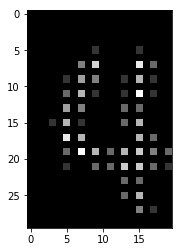

Test_image/Crop_hand/num\4_1.jpg
Predict: number 
True: number


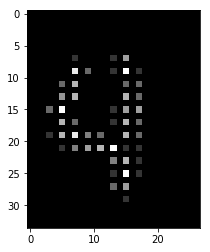

Test_image/Crop_hand/num\6.jpg
Predict: negative 
True: number


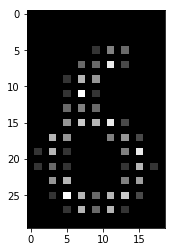

Test_image/Crop_hand/num\8.jpg
Predict: number 
True: number


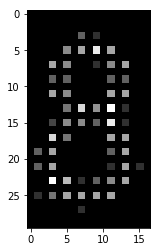

Test_image/Crop_hand/num\9.jpg
Predict: number 
True: number


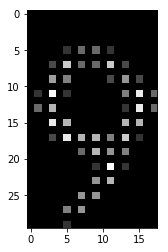

Test_image/Crop_hand/num\9_2.jpg
Predict: number 
True: number


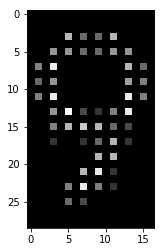

Test_image/Crop_hand/num\slash.jpg
Predict: number 
True: number


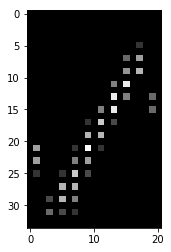

In [9]:
from categories import label_mid

walking = os.walk("Test_image/Crop_hand/num")
paths = []
for walk in walking:
    for w2 in walk[2]:
        paths.append(os.path.join(walk[0], w2))
        
img_types = ["png", "jpg", "jpeg"]
for path in paths:
    clss = {}
    print(path)
    if path.split(".")[-1] in img_types:
        img = cv2.imread(path, 0)
        _, thresh = cv2.threshold(img, 155, 255, cv2.THRESH_BINARY)
        skeletonized = skeletonize(255 - thresh)
        hog_feature, hog_img = hog(skeletonized, orientations=32, pixels_per_cell=(2, 2),
                                   cells_per_block=(1, 1), visualise=True)
        rgb_batch = np.repeat(hog_img[..., np.newaxis], 3, -1)
        for i in range(1, rng):
            resized = cv2.resize(rgb_batch, (dct["model{}".format(i)].layers[0].input_shape[2], dct["model{}".format(i)].layers[0].input_shape[1]))
            img_s = np.expand_dims(resized, axis=0)
            clss["model{}".format(i)] = dct["model{}".format(i)].predict(img_s)
        cls = ensemble(clss, threshold=0.1)
        print("Predict:", config.classes[cls[0]], "\nTrue: number")
        plt.imshow(hog_img, cmap='gray')
        plt.show()

In [ ]:
walking = os.walk("Test_image\Crop_hand\mid")
paths = []
for walk in walking:
    for w2 in walk[2]:
        paths.append(os.path.join(walk[0], w2))
        
img_types = ["png", "jpg", "jpeg"]
for path in paths:
    clss = {}
    print(path)
    if path.split(".")[-1] in img_types:
        img = cv2.imread(path, 0)
        _, thresh = cv2.threshold(img, 155, 255, cv2.THRESH_BINARY)
        skeletonized = skeletonize(255 - thresh)
        hog_feature, hog_img = hog(skeletonized, orientations=32, pixels_per_cell=(2, 2),
                                   cells_per_block=(1, 1), visualise=True)
        rgb_batch = np.repeat(hog_img[..., np.newaxis], 3, -1)
        for i in range(1, rng):
            resized = cv2.resize(rgb_batch, (dct["model{}".format(i)].layers[0].input_shape[2], dct["model{}".format(i)].layers[0].input_shape[1]))
            img_s = np.expand_dims(resized, axis=0)
            clss["model{}".format(i)] = dct["model{}".format(i)].predict(img_s)
        cls = ensemble(clss)
        print("Predict:", config.classes[cls[0]], "\nTrue: negative")
        plt.imshow(hog_img, cmap='gray')
        plt.show()